*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>



***

## Contents

## Introduction
### Permissions
### An Overview of the data

## 

## Introduction
Imagine that you travel to a city that you have never been to. You do not have friends here, but you want to know where is the best restaurant in the city. If this scenario happened in 10 years ago, you might want to ask a passingby for advice or just randomly picked a restaurant that looked good. But now, you have **Yelp**, which publishes crowd-sourced reviews about local businesses and provide comprehensive information about every aspect of local businesses. Using **Yelp**, you have access to **148 million** reviews provided by different users around the world.

These reviews not only benefit users, but also form a huge and valuable dataset. There are two unique characteristics about this dataset, 
1. This dataset contains almost everything about local businesses. 
2. The dataset contains reviews provided by real users.

Based on two characteristics, we want to implement further investigation using this dataset. They are listed as following, 
1. Characteristics of all Businesses in the dataset, Including their popularity, location, etc.
2. Characteristics of Businesses in the dataset in a particular region, compare it with the whole data set. Since we are in Toronto, so we will do investigation on the GTA.
3. Characteristics of reviews in the dataset, and make connection with users and reviews.

The purpose of the investigation is to benefit the businesses, and provide **Yelp** more suggestions to improve their review. This report will not go beyond these two purposes. 
### Permissions
We will use the data provided by **Yelp Inc.**, it is our obligation to understand the laws and regulations of the dataset. I will explain them using the **YELP DATASET TERMS OF USE** in terms of what we can do and we can't do.
1. What we **Can** do
**Acadamic Purpose**
The purpose of using this dataset should be fully under an acadamic purpose. For example, you may use the data to develop a research about local businesses for an assignment in the school. For other purposes of using the dataset, we have to ask **Yelp Inc.** for extra authority.
**Risk**
We have to understand the risk to take. 
2. What we **Can't** do
**Commerical Purpose**
The data set should not be used for any commerical purposes. For instance, we cannot use the dataset to benefit our own local business by updating or creating our own business listing information. 
**Violation of Laws**
Any usage of this dataset that violates the law and regulation should not be permitted?

### An Overview of the data

I will go through important attributes of datasets one by one and then describe the relationship between attributes in datasets.

## Characteristics of All Businesses

In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
import geopandas as geopd
import math
import geopy.distance
from nltk.corpus import wordnet as wn
import  nltk
import re

In [2]:
bussiness_df = pd.read_json('yelp_dataset/business.json', lines=True)

We know this dataset is a subset of all businesses stored in Yelp in the world. So, we first need to know more about the data, including **which cities does the city emcompass?** This questions can be divided into 2 subquestions.
1. Where do these cities locate at (country, states)?
2. Which cities contain most businesses in the data set?

The most intuitive way for us to view the allocation is through map. Using longititude and latitude provided in the dataset, we can plot locations of businesses in the dataset. 

In [3]:
world_map = geopd.read_file(
    geopd.datasets.get_path('naturalearth_lowres')) # read world map

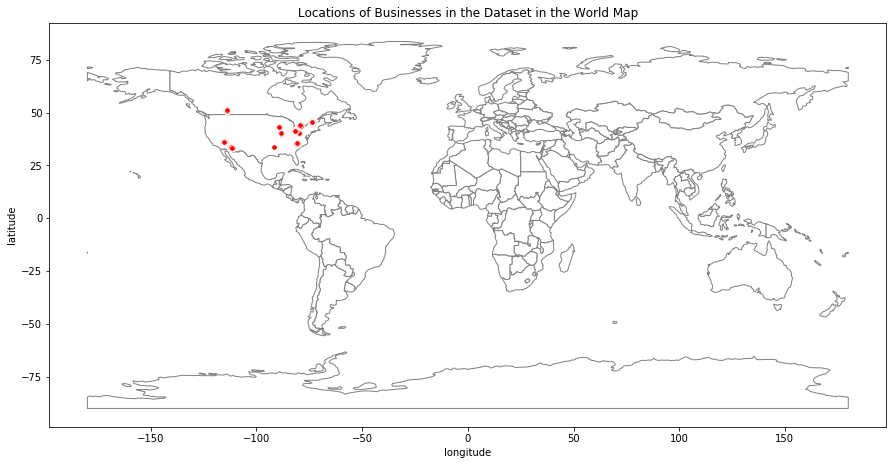

In [11]:
base = world_map.plot(edgecolor = 'grey', color = 'white', figsize=(15,10))
sns.scatterplot(x = "longitude", y = "latitude", 
                       data = bussiness_df, s = 30, color = 'red', ax = base)
plt.title('Locations of Businesses in the Dataset in the World Map')
plt.show()

We see all cities that contain business in the dataset are located in North America, in particular, the **United States** and **Canada**. From the world map, we can also see these cities are not widely spread in two contries, instead, they are concentrated in some parts. The next step is to find how many businesses are there in each country. The data set does not tell the country directly, but we can use the post code to determine country (Postcode in US only contains digits). I will use piechart to visualize them.

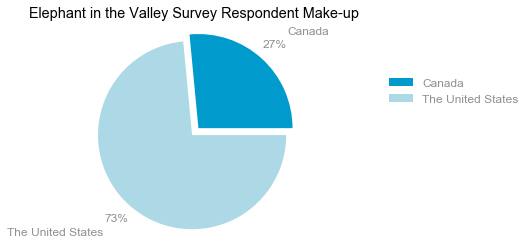

In [17]:
# group them by country
def group_by_country(df):
    country = []
    for index, row in df.iterrows():
        if row['postal_code'].isdigit():
            country.append('United States')
        else:
            country.append('Canada')
    df['country'] = country
group_by_country(bussiness_df)
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Canada', 
         'The United States']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
Canada_Total = bussiness_df[bussiness_df['country'] == 'Canada'].shape[0]
United_States_Total = bussiness_df[bussiness_df['country'] == 'United States'].shape[0]
Total = bussiness_df.shape[0]
percentages = [Canada_Total / Total, United_States_Total / Total]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

From the piechart, we see about 3 quarters of businesses are located in the United States, rest of them are in Canada.
The next step is to figure out which states in these two countries contain those cities with businesses. Let's print out the list of the states first. Surprisingly, we find some states that do not have 2-letter-abbreviation. Obviously, they are not name of states in the US or Canada. Let's take a look of what is behind these states.

In [13]:
bussiness_df.state.unique() 

array(['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'QC', 'WI', 'IL', 'NY',
       'SC', 'TX', 'UT', 'NM', 'FL', 'CA', 'VA', 'BAS', 'NE', 'AK', 'XGM',
       'WA', 'XWY', 'CON', 'BC', 'GA', 'VT', 'CT', 'AL', 'DUR', 'TN',
       'NJ', 'AR', 'XGL', 'DOW'], dtype=object)

In [14]:
bussiness_df[((bussiness_df['state'] =='XGL') | (bussiness_df['state'] =='XGM') |
              (bussiness_df['state'] =='DUR') | (bussiness_df['state'] =='DOW') | (bussiness_df['state'] =='CON') |
             (bussiness_df['state'] =='BAS') | (bussiness_df['state'] =='XWY'))]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
27744,d4qoXn1Rqt47LLTDA3bAwQ,Thayer David Ice Cream Shop,8 York St,Bath,BAS,BA1 1NG,43.640646,-79.380939,4.0,4,1,{'RestaurantsPriceRange2': '1'},"Food, Ice Cream & Frozen Yogurt",None
33265,8_GNJU3EPar9VkPzJvoC3w,Bean & Brush Family Art Café,"The Old Sorting Office, 12 Hayfield Street",Sale,XGM,M33 7XW,42.996059,-89.568889,4.0,4,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Arts & Crafts, Shopping, Coffee & Tea, Food","{'Monday': '8:30-19:0', 'Tuesday': '8:30-19:0'..."
35255,JNZeVq9jr9AWURmnM-Yxig,Total Gardening and Landscaping,,Bury,XGM,BL8 4DR,42.996059,-89.568889,5.0,3,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Home Services, Landscaping, Tree Services, Gar...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
39022,6dhkHf-CFHr7C8wj-qopCQ,Paper Cutz,"Gorebrook Works, Pinkbank Lane",Manchester,XGM,M12 5GH,42.996059,-89.568889,2.5,3,1,"{'BusinessParking': '{'garage': False, 'valida...","Art Supplies, Arts & Crafts, Shopping",None
54920,44xjnQMwAQjgZ80MW5z-Gg,No. 37 Sandwich Bar,37 Monk Bridge Road,Leeds,XWY,LS6 4EP,45.456999,-73.595250,4.5,3,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Bakeries, Food, Desserts, Restaurants, Sandwiches","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ..."
58669,eeEcf7XXAGClqdUCwnwRfg,The Old Lifeboat House,"The Cove, Coverack Helston",Church Cove,CON,TR12 6SX,35.532021,-80.851682,3.5,3,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","British, Restaurants",None
127476,svMJjPd4l_Zb_MoxejYZvw,Zoom Printing,"1136 Center Street, Suite 442",Thornhill,DUR,L4J 3M8,43.808563,-79.463806,3.5,3,1,None,"Professional Services, Advertising, Printing S...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
133170,FByZsT1Sob5Vf1AYJFPxPg,Desi Masala,61 Queen Street,Leeds,XWY,LS27 8EB,43.652821,-79.376345,4.5,5,1,"{'RestaurantsReservations': 'True', 'NoiseLeve...","Indian, Pakistani, Restaurants",None
144601,ZsL7FUkaWdyQnDoYB6XpSA,Happy Gathering Resturant Oldham,,Oldham,XGM,OL2 6PX,42.996059,-89.568889,4.0,3,1,None,"Chinese, Restaurants",None
179148,xjR-PII302WyyNRfpcowDg,Moxon's Fishmongers,110 Islington High Street,London,XGL,N1 8EG,43.645355,-79.524467,4.5,3,1,"{'WheelchairAccessible': 'True', 'BusinessAcce...","Specialty Food, Food, Seafood Markets","{'Tuesday': '9:0-19:30', 'Wednesday': '9:0-19:..."


From the dataset, we see there must be mistakes when recording these businesses. Since the states and cities indicate that they are European cities, but their latitudes and longitudes show that they are actually in US and Canada. Since the total length of our dataset is more than 190000, and wrong data only contain 11 businesses, so, dropping them will not affect the result too much, I will drop them for now.

In [19]:
bussiness_df = bussiness_df[~((bussiness_df['state'] =='XGL') | (bussiness_df['state'] =='XGM') |
              (bussiness_df['state'] =='DUR') | (bussiness_df['state'] =='DOW') | (bussiness_df['state'] =='CON') |
             (bussiness_df['state'] =='BAS') | (bussiness_df['state'] =='XWY'))]
# Split it into two dataframes by country
Canada_bussiness_df = bussiness_df[bussiness_df['country'] == 'Canada']
United_States_bussiness_df = bussiness_df[bussiness_df['country'] == 'United States']

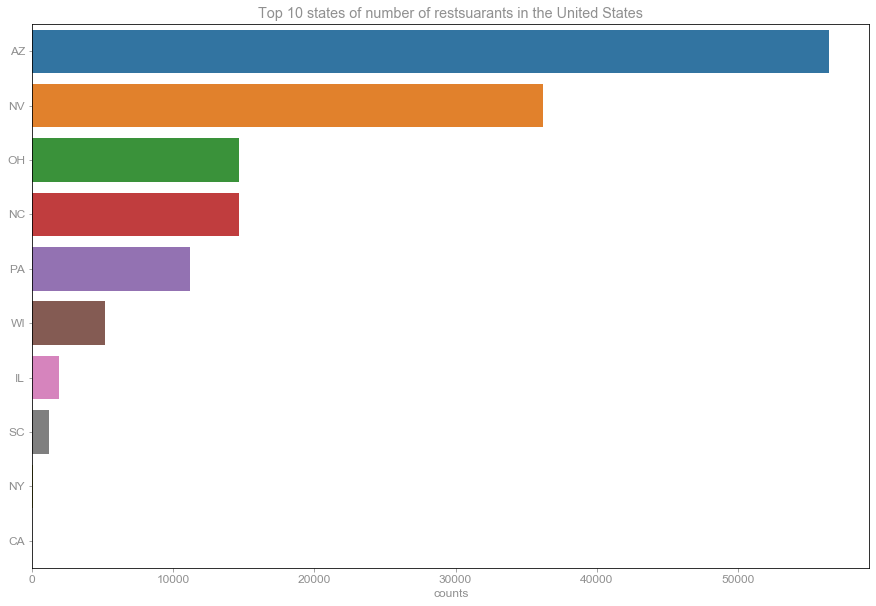

In [23]:
top_10_states_us = pd.DataFrame(United_States_bussiness_df['state'].value_counts().head(10))
top_10_states_us.columns = ["counts"]
plt.figure(figsize = (15, 10))
sns.barplot(y = top_10_states_us.index, x= top_10_states_us.counts, orient = 'h')
plt.title('Top 10 states of number of restsuarants in the United States')
plt.show()

From this bar plot, and combine it with the map above, we see most bussinesses in the United States are concentrated in cities in 5 states. They are Arizona, Nevada, Ohio, North Dakota, Pennsylvania. Now, since we know different cities may have the same name, so I will use both state and city to determine what are the cities with the most number of businesses.

In [44]:
pd.DataFrame(United_States_bussiness_df[['state','city']]).groupby(["state", "city"]).size().reset_index(name="Counts").sort_values(by=['Counts'], ascending=False).head(10)

,state,city,Counts
285,NV,Las Vegas,29273
76,AZ,Phoenix,18672
196,NC,Charlotte,9467
102,AZ,Scottsdale,8812
713,PA,Pittsburgh,6996
59,AZ,Mesa,6064
276,NV,Henderson,4882
119,AZ,Tempe,4538
26,AZ,Chandler,4297
378,OH,Cleveland,3592


From the table above, we see Las Vegas in Nevada has the highest count of bussiness. And all the top 10 cities has at least 3000 businesses in the city.

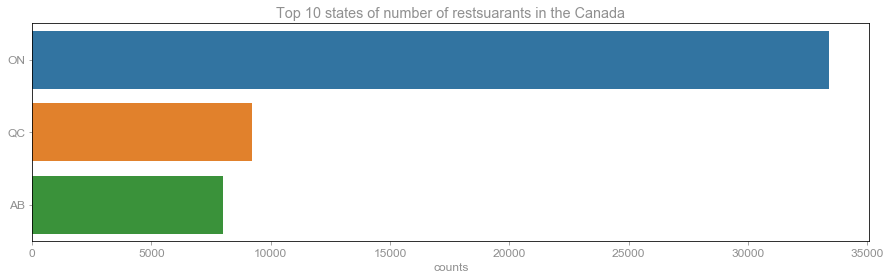

In [48]:
top_10_states_ca = pd.DataFrame(Canada_bussiness_df['state'].value_counts().head(3))
top_10_states_ca.columns = ["counts"]
plt.figure(figsize = (15, 4))
sns.barplot(y = top_10_states_ca.index, x= top_10_states_ca.counts, orient = 'h')
plt.title('Top 10 states of number of restsuarants in the Canada')
plt.show()

In Canada, we see most cities are concentrated in Ontario, Québec, and Alberta

In [49]:
pd.DataFrame(Canada_bussiness_df[['state','city']]).groupby(["state", "city"]).size().reset_index(name="Counts").sort_values(by=['Counts'], ascending=False).head(10)

,state,city,Counts
184,ON,Toronto,18904
5,AB,Calgary,7734
313,QC,Montréal,6449
136,ON,Mississauga,3112
130,ON,Markham,1766
148,ON,North York,1204
171,ON,Scarborough,1103
167,ON,Richmond Hill,1025
87,ON,Brampton,1002
193,ON,Vaughan,919


From the table above, we see Toronto in Ontario has the highest count of bussiness. Except Calgary and Montréal, most cities in Canada are in Ontario, in the great Toronto area.

 ### Category
The category of business is another important feature to investigate. A business may have several categories. We want to investigate the category to see what is the most common catrgory in this dataframe. First, let's look at how may combination of categories we have in the data set.

In [55]:
print("There are", len(bussiness_df.categories.unique()), "combination of categories in this dataset.")

There are 93382 combination of categories in this dataset.


It is a huge number, so instead of counting the number of combinations of categories, we will count the apperance of each category in the dataset.

In [56]:
def check_unique_category(df):
    category_dict = {}
    for index, row in df.iterrows():
        if None == row['categories']:
            continue
        else:
            for category in [i.strip() for i in row['categories'].split(',')]:
                if category not in category_dict:
                    category_dict[category] = 1
                else:
                    category_dict[category] = category_dict[category] + 1
    return category_dict

In [58]:
unique_category = check_unique_category(bussiness_df)
category_count = pd.DataFrame.from_dict(unique_category,orient='index')
category_count.columns = ['counts']
category_count.sort_values(by=['counts'], ascending=False, inplace = True)
category_count_top_10 = category_count.head(10)

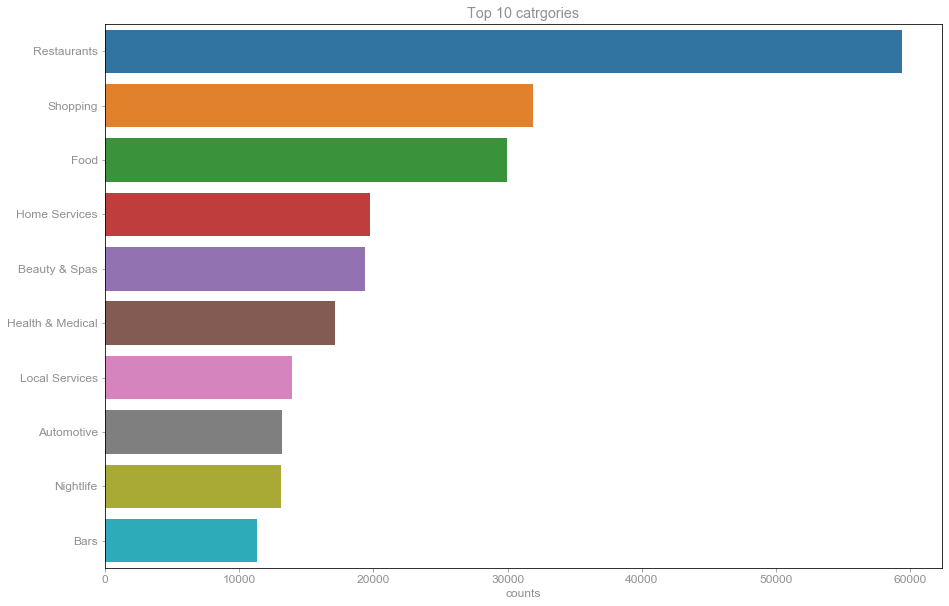

In [60]:
plt.figure(figsize = (15, 10))
sns.barplot(y = category_count_top_10.index, x= category_count_top_10.counts, orient = 'h')
plt.title('Top 10 catrgories')
plt.show()

From the plot, we see restaurants are definitely the most frequent business in the datsset, we have more than 60000 restaurants in the dataset, which means about one thrid of the businesses are related to resuaurants. Shopping, and food categories follow restaurants. Notice that reaurants have some 'subcategories' are also in the list. It would be better for us to split the data set into two parts, one is restaurant business, the other is "not restaurant" businesses. By doing this, we can have a better understanding of the popularity of different types of foods.

In [61]:
def check_restaurant(df):
    restaurant = []
    for index, row in df.iterrows():
        if None == row['categories']:
            restaurant.append(False)
        else:
            if 'Restaurants' in [i.strip() for i in row['categories'].split(',')]:
                restaurant.append(True)
            else:
                restaurant.append(False)
    df['restaurant'] = restaurant

In [65]:
check_restaurant(bussiness_df)

In [66]:
without_resuaurant = bussiness_df[~bussiness_df['restaurant']]
resuaurant = bussiness_df[bussiness_df['restaurant']]
without_resuaurant_category = pd.DataFrame.from_dict(check_unique_category(without_resuaurant), orient='index')
without_resuaurant_category.columns = ['counts']
without_resuaurant_category.sort_values(by=['counts'], ascending=False, inplace = True)
without_resuaurant_category = without_resuaurant_category.head(10)

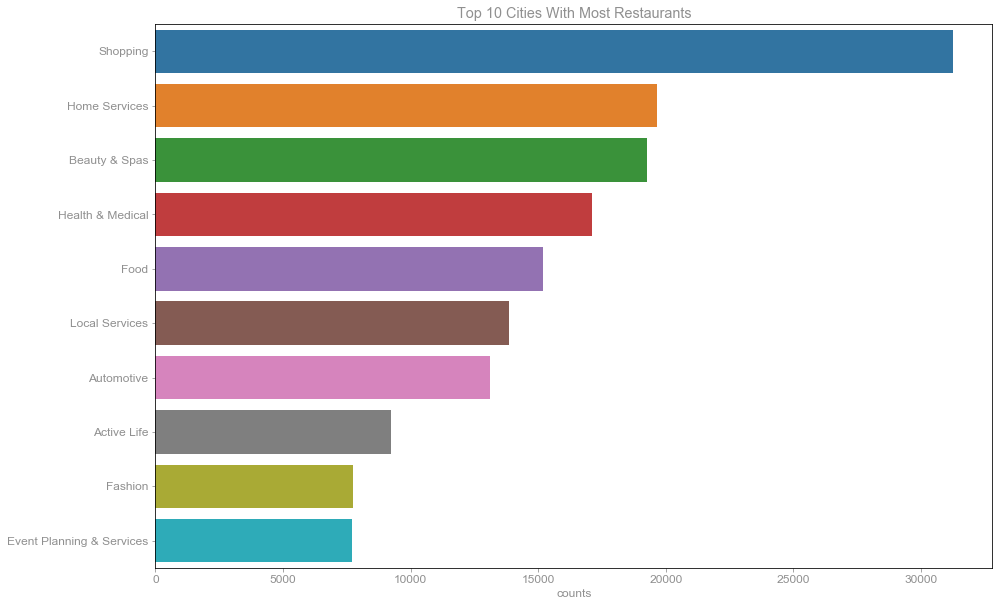

In [68]:
plt.figure(figsize = (15, 10))
sns.barplot(y = without_resuaurant_category.index, x= without_resuaurant_category.counts, orient = 'h')
plt.title('Top 10 non-Restaurant Category')
plt.show()

Among all non-restaurants businesses, we see shopping catogory has the highest frequency. Home serivices, Beauty & Spas and Health & Medical also have the frequency higher than 15000, indicates that more than 1 percentage of bussinesses in this data set are related to these 3 categories.

In [148]:
resuaurant_category = pd.DataFrame.from_dict(check_unique_category(resuaurant), orient='index')
resuaurant_category.columns = ['counts']
resuaurant_category = resuaurant_category.sort_values(by=['counts'], ascending=False).drop(['Restaurants', 'Food'])
resuaurant_category_top_10 = resuaurant_category.head(10)

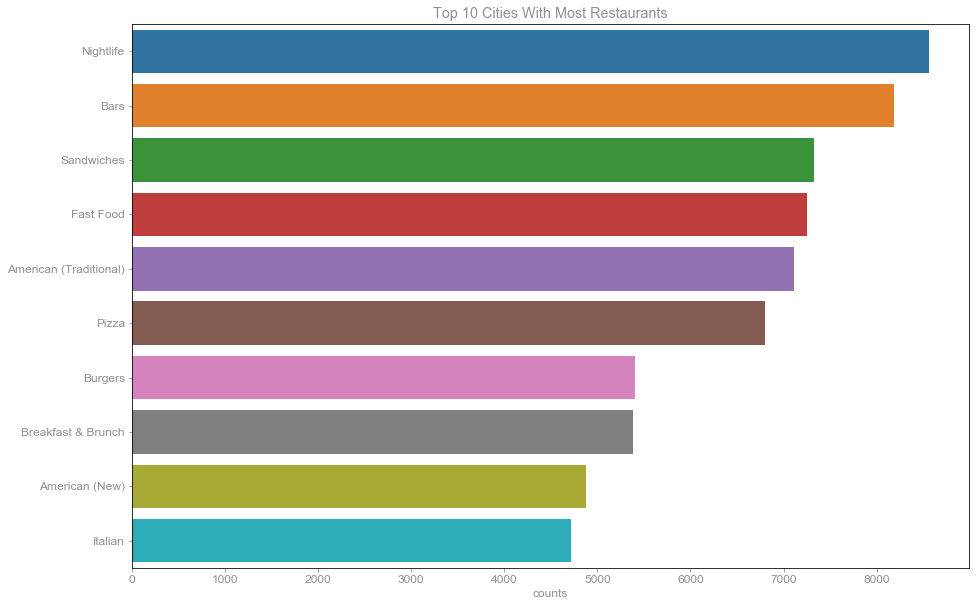

In [149]:
plt.figure(figsize = (15, 10))
sns.barplot(y = resuaurant_category_top_10.index, x= resuaurant_category_top_10.counts, orient = 'h')
plt.title('Top 10 Cities With Most Restaurants')
plt.show()

From the bar plot, we see the top 10 categories of restaurant types are evenly distributed. There is not a huge difference between two catrgories in terms of number of restaurants. Among all restaurants, nightlife and bar restaurants have the most number of businesses. Notice that fast food including pizza and burger is another category of restaurants that has a huge number.

### Bike Parking
The convenience of establisment is also an important thing to consider about for a bussiness. One important indicator of convenience is the bike parking facility of the establisment. So, I will implement further investigation on Bike Parking condition: **what types of establishments tend to have bike parking?**
I will define  establisment in two ways, one is its **category**, the other is its **attribute** (Notice that a business may have multiple attributes, but I will count the occurance of them and find top 20 attributes with bike parking.)

In [82]:
def check_bike_parking(df):
    bike_parking = []
    for index, row in df.iterrows():
        if row['attributes'] == None:
            bike_parking.append(np.nan)
        else:
            if "BikeParking" in row['attributes']:
                if row['attributes']['BikeParking'] == 'True':
                    bike_parking.append(True)
                else:
                     bike_parking.append(False)
            else:
                bike_parking.append(np.nan)
    return bike_parking

In [ ]:
bussiness_df['Bike Parking Availability'] = check_bike_parking(bussiness_df)
bike_parking_available_df = bussiness_df[bussiness_df['Bike Parking Availability'] == True]
bike_parking_available_df.shape[0]
bike_parking_available = pd.DataFrame.from_dict(check_unique_category(bike_parking_available_df), orient='index')
bike_parking_available.shape[0]
bike_parking_available.columns = ['counts']
bike_parking_available.sort_values(by=['counts'], ascending=False, inplace = True)
bike_parking_available = bike_parking_available.head(10)

In [87]:
bike_parking_available

,counts
Restaurants,29478
Food,17403
Shopping,15291
Beauty & Spas,10632
Nightlife,7314
Bars,6706
Active Life,4806
Coffee & Tea,4628
American (Traditional),4186
Sandwiches,3986


From the table above, we clearly see restaurant has the highest number of of bike establisments.

In [89]:
def check_attributes(df):
    attributes_count = {}
    for index, row in df.iterrows():
        if row['attributes'] == None:
            continue
        else:
            for key in row['attributes'].keys():
                value = row['attributes'][key]
                if '{' not in value:
                    newkey = (key, value)
                    if newkey not in attributes_count:
                        attributes_count[newkey] = 1
                    else:
                        attributes_count[newkey] += 1
                else:
                    sub_dict = ast.literal_eval(value)
                    for subkey in sub_dict:
                        newkey = (key+','+subkey, sub_dict[subkey])
                        if newkey not in attributes_count:
                            attributes_count[newkey] = 1
                        else:
                            attributes_count[newkey] += 1
    return attributes_count
attributes_count = check_attributes(bike_parking_available_df)
attributes = [i[0] for i in list(attributes_count.keys())]
values =  [i[1] for i in list(attributes_count.keys())]
counts = [i for i in list(attributes_count.values())]
attributes_count_df = pd.DataFrame({"attributes": attributes, "values": values, "counts":counts})
attributes_count_df = attributes_count_df.sort_values(by=['counts'], ascending=False)
attributes_count_df.head(10)

,attributes,values,counts
32,BikeParking,True,66330
25,"BusinessParking,validated",False,60506
27,"BusinessParking,valet",False,59989
23,"BusinessParking,garage",False,57644
24,"BusinessParking,street",False,46296
13,BusinessAcceptsCreditCards,True,44258
34,RestaurantsPriceRange2,2,35842
12,RestaurantsTakeOut,True,33199
36,"BusinessParking,lot",False,32516
0,GoodForKids,True,29689


In [171]:
attributes_total = check_attributes(bussiness_df)
attributes = [i[0] for i in list(attributes_total.keys())]
values =  [i[1] for i in list(attributes_total.keys())]
counts = [i for i in list(attributes_total.values())]
attributes_total_df = pd.DataFrame({"attributes": attributes, "values": values, "counts":counts})

In [182]:
ratio_df = pd.merge(attributes_total_df, attributes_count_df,  how='right', left_on=['attributes','values'], right_on = ['attributes','values'])
ratio_df['ratio'] = ratio_df['counts_y'] / ratio_df['counts_x']

In [184]:
ratio_df.sort_values(by=['ratio'], ascending=False)

,attributes,values,counts_x,counts_y,ratio
207,Smoking,'yes',3,3,1.000000
40,BikeParking,True,66330,66330,1.000000
217,"DietaryRestrictions,halal",True,3,3,1.000000
206,DietaryRestrictions,None,7,6,0.857143
159,"BestNights,tuesday",True,411,350,0.851582
...,...,...,...,...,...
168,RestaurantsGoodForGroups,None,42,7,0.166667
151,BusinessAcceptsCreditCards,None,114,17,0.149123
160,RestaurantsAttire,None,48,6,0.125000
152,ByAppointmentOnly,None,124,15,0.120968


From the table above, we clearly see BikeParking has the highest number of of bike establisments.
So in the next time, if you want to ride a bike

### Reviews and Rating
 According to an article that was published recently, having more yelp reviews result in a higher rating, and this helps increase the sales indirectly. Using the dataset we have, we can investigate this relationship deeper than random guessing. Let's first take a look at two attributes.

In [90]:
bussiness_df[['review_count', 'stars']].describe()

,review_count,stars
count,192598.000000,192598.000000
mean,33.540681,3.585608
std,110.138135,1.018471
min,3.000000,1.000000
25%,4.000000,3.000000
50%,9.000000,3.500000
75%,25.000000,4.500000
max,8348.000000,5.000000


The standard deviation for review counts is of greater magnitude than its mean can indicate that there may be several outliers with very high review counts (also because of mean is higher than median value of this attribute). Therefore, the correlation of these two variables may be deeply influenced by those outliers. However, the restaurants with extremely high review counts are also important to our result, so we can not just simply drop them.

So the procedure I chose for this question is through arrange 'review_count' attribute into 5 categorical value: 0 to 20(th)percentile, 20 to 40(th)percentile, 40 to 60(th)percentile, 60 to 80(th)percentile, 80 to 100(th)percentile. And combine 'stars' attribute into 5 categorical variable, 1.0 to 1.5 star, 2.0 to 2.5 star, 3.0 to 3.5 star,  4.0 to 4.5 star, 5.0 star. And visualize the relationship using stacked bar plot.

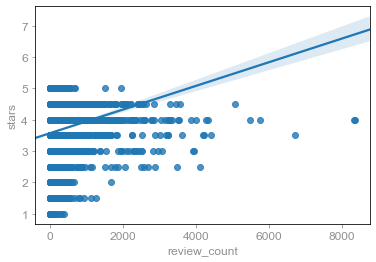

In [91]:
ax = sns.regplot(x="review_count", y="stars", data=bussiness_df)

In [92]:
percentile_20 = bussiness_df['review_count'].quantile(.2)
percentile_40 = bussiness_df['review_count'].quantile(.4)
percentile_60 = bussiness_df['review_count'].quantile(.6)
percentile_80 = bussiness_df['review_count'].quantile(.8)

In [95]:
def group_by_percentile(df, percentile_20, percentile_40, percentile_60, percentile_80):
    percentile = []
    for index, row in df.iterrows():
        if row['review_count'] > percentile_80:
            percentile.append('80_percentile')
        elif row['review_count'] > percentile_60:
            percentile.append('60_percentile')
        elif row['review_count'] > percentile_40:
            percentile.append('40_percentile')
        elif row['review_count'] > percentile_20:
            percentile.append('20_percentile')
        else:
            percentile.append('0_percentile')
    return percentile

In [96]:
bussiness_df['review_count_percentile'] = group_by_percentile(bussiness_df, percentile_20, percentile_40, percentile_60, percentile_80)

In [97]:
star_review = bussiness_df[['stars', 'review_count_percentile']]

In [98]:
def group_star_review(df):
    return [df[(df['stars'] >= 1.0) & (df['stars'] < 2.0)].shape[0], 
                 df[(df['stars'] >= 2.0) & (df['stars'] < 3.0)].shape[0],
                 df[(df['stars'] >= 3.0) & (df['stars'] < 4.0)].shape[0],
                 df[(df['stars'] >= 4.0) & (df['stars'] < 5.0)].shape[0],
                 df[(df['stars'] >= 5.0)].shape[0]]

In [99]:
percentile_0 = group_star_review(star_review[star_review['review_count_percentile'] == '0_percentile'])
percentile_20  = group_star_review(star_review[star_review['review_count_percentile'] == '20_percentile'])
percentile_40 = group_star_review(star_review[star_review['review_count_percentile'] == '40_percentile'])
percentile_60 =  group_star_review(star_review[star_review['review_count_percentile'] == '60_percentile'])
percentile_80 =  group_star_review(star_review[star_review['review_count_percentile'] == '80_percentile'])

The chart indicates that the business above 80 has a different trend of, let'a apply the same procedure to see if there is a different relationship.

In [100]:
above_80_percentile = bussiness_df[bussiness_df['review_count_percentile'] == '80_percentile']
above_80_percentile_20 = above_80_percentile['review_count'].quantile(.2)
above_80_percentile_40 = above_80_percentile['review_count'].quantile(.4)
above_80_percentile_60 = above_80_percentile['review_count'].quantile(.6)
above_80_percentile_80 = above_80_percentile['review_count'].quantile(.8)
above_80_percentile['above_80_review_count_percentile'] = group_by_percentile(above_80_percentile, above_80_percentile_20,
                                                                              above_80_percentile_40, above_80_percentile_60, above_80_percentile_80)
above_80_percentile_star_review = above_80_percentile[['stars', 'above_80_review_count_percentile']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


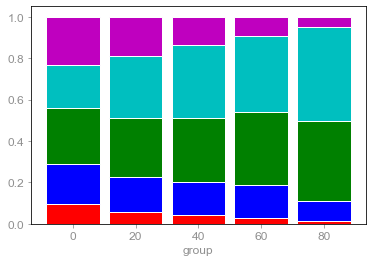

In [101]:
# Data
r = [0,1,2,3,4]

percentile_0 = group_star_review(star_review[star_review['review_count_percentile'] == '0_percentile'])
percentile_20 = group_star_review(star_review[star_review['review_count_percentile'] == '20_percentile'])
percentile_40 = group_star_review(star_review[star_review['review_count_percentile'] == '40_percentile'])
percentile_60 =  group_star_review(star_review[star_review['review_count_percentile'] == '60_percentile'])
percentile_80 =  group_star_review(star_review[star_review['review_count_percentile'] == '80_percentile'])
# From raw value to percentage
totals = [sum(percentile_0), sum(percentile_20), sum(percentile_40), sum(percentile_60), sum(percentile_80)]
star_1 = [percentile_0[0] / totals[0], percentile_20[0] / totals[1], percentile_40[0] / totals[2], percentile_60[0] / totals[3], percentile_80[0] / totals[4]]
star_2 = [percentile_0[1] / totals[0], percentile_20[1] / totals[1], percentile_40[1] / totals[2], percentile_60[1] / totals[3], percentile_80[1] / totals[4]]
star_3 = [percentile_0[2] / totals[0], percentile_20[2] / totals[1], percentile_40[2] / totals[2], percentile_60[2] / totals[3], percentile_80[2] / totals[4]]
star_4 = [percentile_0[3] / totals[0], percentile_20[3] / totals[1], percentile_40[3] / totals[2], percentile_60[3] / totals[3], percentile_80[3] / totals[4]]
star_5 = [percentile_0[4] / totals[0], percentile_20[4] / totals[1], percentile_40[4] / totals[2], percentile_60[4] / totals[3], percentile_80[4] / totals[4]]

# plot
barWidth = 0.85
names = ('0','20','40','60','80')
# Create green Bars
plt.bar(r, star_1, color='r', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, star_2, bottom=star_1, color='b', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, star_3, bottom=[i+j for i,j in zip(star_1, star_2)], color='g', edgecolor='white', width=barWidth)
plt.bar(r, star_4, bottom=[i+j+k for i,j,k in zip(star_1, star_2, star_3)], color='c', edgecolor='white', width=barWidth)
plt.bar(r, star_5, bottom=[i+j+k+u for i,j,k,u in zip(star_1, star_2, star_3, star_4)], color='m', edgecolor='white', width=barWidth)

# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
 
# Show graphic
plt.show()

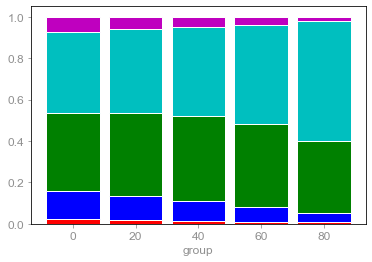

In [102]:
# Data
r = [0,1,2,3,4]

percentile_0 = group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '0_percentile'])
percentile_20 = group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '20_percentile'])
percentile_40 = group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '40_percentile'])
percentile_60 =  group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '60_percentile'])
percentile_80 =  group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '80_percentile'])
# From raw value to percentage
totals = [sum(percentile_0), sum(percentile_20), sum(percentile_40), sum(percentile_60), sum(percentile_80)]
star_1 = [percentile_0[0] / totals[0], percentile_20[0] / totals[1], percentile_40[0] / totals[2], percentile_60[0] / totals[3], percentile_80[0] / totals[4]]
star_2 = [percentile_0[1] / totals[0], percentile_20[1] / totals[1], percentile_40[1] / totals[2], percentile_60[1] / totals[3], percentile_80[1] / totals[4]]
star_3 = [percentile_0[2] / totals[0], percentile_20[2] / totals[1], percentile_40[2] / totals[2], percentile_60[2] / totals[3], percentile_80[2] / totals[4]]
star_4 = [percentile_0[3] / totals[0], percentile_20[3] / totals[1], percentile_40[3] / totals[2], percentile_60[3] / totals[3], percentile_80[3] / totals[4]]
star_5 = [percentile_0[4] / totals[0], percentile_20[4] / totals[1], percentile_40[4] / totals[2], percentile_60[4] / totals[3], percentile_80[4] / totals[4]]

# plot
barWidth = 0.85
names = ('0','20','40','60','80')
# Create green Bars
plt.bar(r, star_1, color='r', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, star_2, bottom=star_1, color='b', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, star_3, bottom=[i+j for i,j in zip(star_1, star_2)], color='g', edgecolor='white', width=barWidth)
plt.bar(r, star_4, bottom=[i+j+k for i,j,k in zip(star_1, star_2, star_3)], color='c', edgecolor='white', width=barWidth)
plt.bar(r, star_5, bottom=[i+j+k+u for i,j,k,u in zip(star_1, star_2, star_3, star_4)], color='m', edgecolor='white', width=barWidth)

# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
 
# Show graphic
plt.show()

## Characteristics of GTA Businesses
Now, it's take to take advantage of this dataset to explore our neighborhood.
From previous deduction, most of the businesses in Canada are concentrated in Ontario. I want to filter bussiness that are located in Ontario.
### GTA data

3.1. What are the most frequent business categories? How do they compare against the trends listed in Part 2?
how do we define GTA From the previous deduction, we see... Therefore, i will choose all cities in Ontario excpet a few outliers.

<Figure size 1080x720 with 0 Axes>

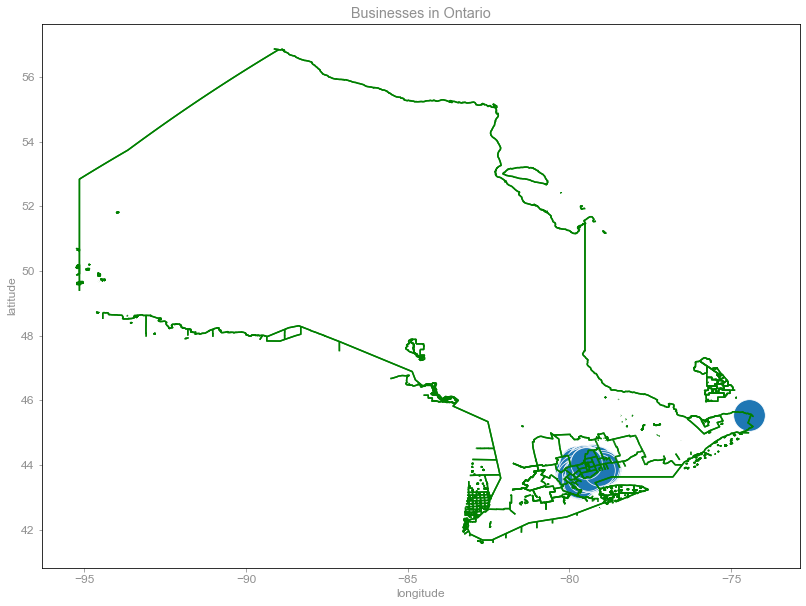

In [116]:
ontario_map = geopd.read_file("ontario_administrative/ontario_administrative.shp")
plt.figure(figsize=(15,10))
base = ontario_map.plot(edgecolor = 'green', figsize=(15,10))
sns.scatterplot(x = "longitude", y = "latitude",  data = bussiness_df[bussiness_df['state'] == 'ON']  , s = 1000, ax=base )
ontario_map.plot(ax = base, edgecolor = 'green')
plt.title('Businesses in Ontario')
plt.show()

From the map, we see most of the data are located in the GTA. While, there is one bussiness located at the right side of Ontario. I will drop them to form a dataframe only contains bussinesses in the GTA.

In [119]:
GTA_business_df  = bussiness_df[(bussiness_df['state'] == 'ON') & (bussiness_df['longitude'] < -76)]

### Category
First, we investigate catrgory of the whole data frame. What about in GTA?

In [120]:
GTA_category = pd.DataFrame.from_dict(check_unique_category(GTA_business_df), orient='index')
GTA_category.columns = ['counts']
GTA_category.sort_values(by=['counts'], ascending=False, inplace = True)
GTA_category_top10 = GTA_category.head(10)

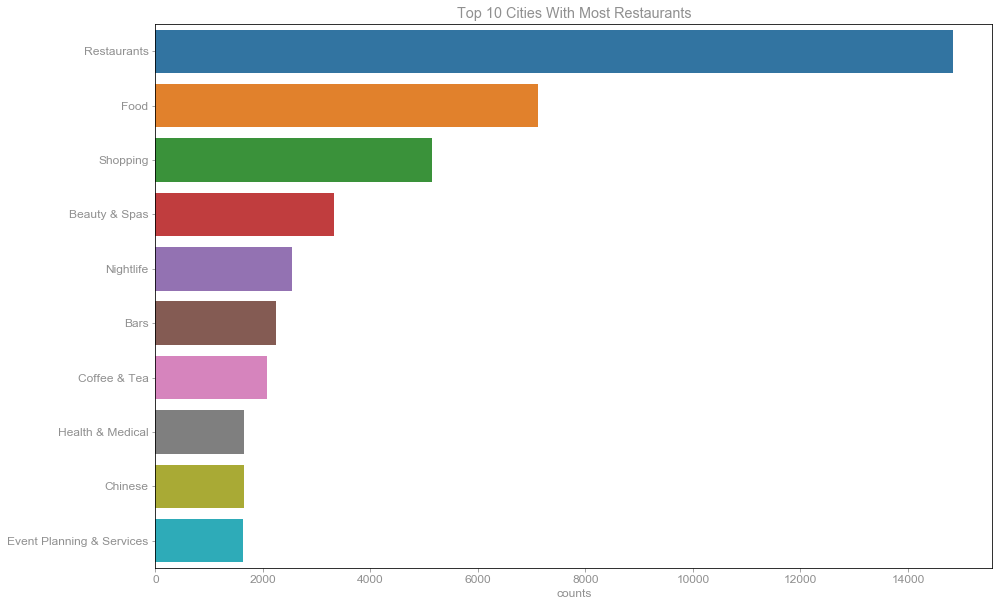

In [121]:
plt.figure(figsize = (15, 10))
sns.barplot(y = GTA_category_top10.index, x= GTA_category_top10.counts, orient = 'h')
plt.title('Top 10 Cities With Most Restaurants')
plt.show()

In [122]:
GTA_category["ranking_GTA"] = [i for i in range(1, GTA_category.shape[0]+1)]
category_count["ranking_All"] = [i for i in range(1, category_count.shape[0]+1)]
category_rank = pd.merge(GTA_category, category_count, left_index=True, right_index=True)
category_rank['Difference'] = category_rank['ranking_GTA'] - category_rank['ranking_All']

In [132]:
category_rank.sort_values(by=['Difference'], ascending=False).drop(['counts_x', 'counts_y', 'ranking_GTA','ranking_All'], axis = 1)

,Difference
Boot Camps,622
Auto Customization,591
Rehabilitation Center,532
Shaved Ice,519
Pool & Hot Tub Service,510
...,...
Hakka,-463
Slovakian,-464
3D Printing,-476
South African,-476


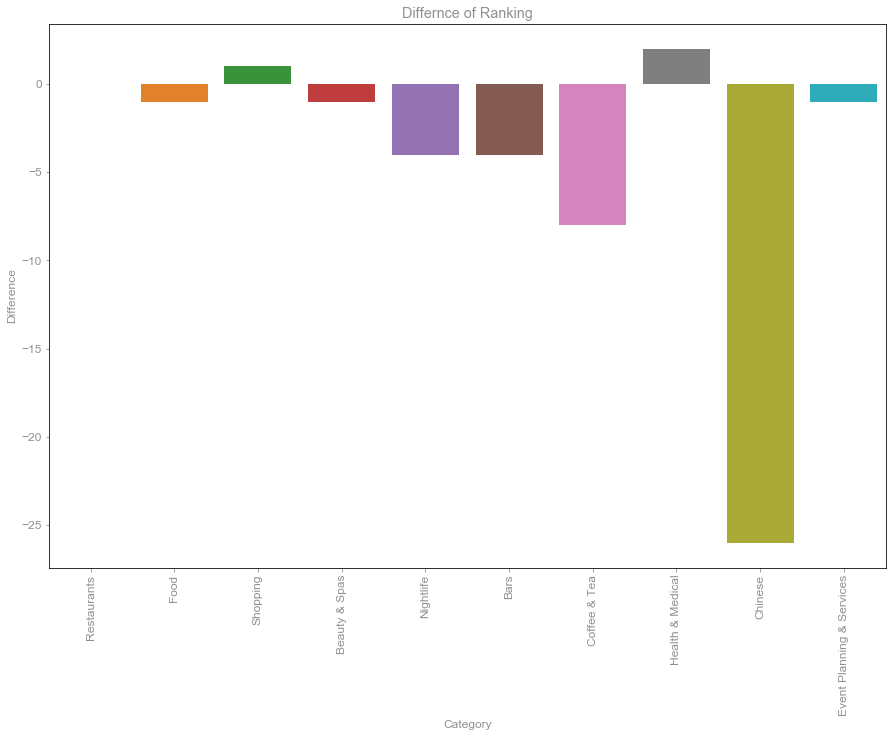

In [152]:
plt.figure(figsize = (15, 10))
sns.barplot(x="index", y="Difference", data=category_rank.head(10).reset_index())
plt.title('Differnce of Ranking')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

From the plot, we see restaurant still keeps its leading position. Food category and shopping reverse their ranking.There is also no dramatic increase or decrease for other categories. One exception is Chinese(food), it rank increases dramtically to 9th position in the GTA. It ranked 35 in the ranking of the whole data set. This is an interesting feature to investigate, since Toronto is one of the most diverse cities in the world, it is reasonable that this city has a large number of foreign restaurants.

In [150]:
GTA_resuaurant_category = pd.DataFrame.from_dict(check_unique_category(GTA_business_df[GTA_business_df['restaurant'] == True]), orient='index')
GTA_resuaurant_category.columns = ['counts']
GTA_resuaurant_category = GTA_resuaurant_category.sort_values(by=['counts'], ascending=False).drop(['Restaurants', 'Food'])
GTA_resuaurant_category = GTA_resuaurant_category.head(10)
GTA_resuaurant_category["ranking_GTA"] = [i for i in range(1, GTA_resuaurant_category.shape[0]+1)]
resuaurant_category["ranking_All"] = [i for i in range(1, resuaurant_category.shape[0]+1)]
resuaurant_category_rank = pd.merge(GTA_resuaurant_category, resuaurant_category, left_index=True, right_index=True)
resuaurant_category_rank['Difference'] = resuaurant_category_rank['ranking_GTA'] - resuaurant_category_rank['ranking_All']

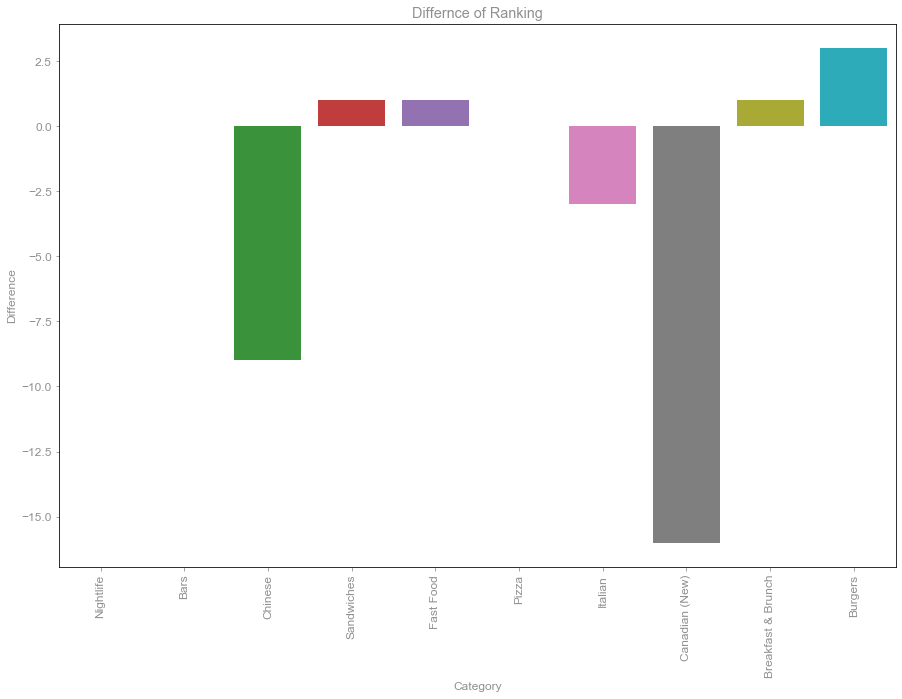

In [154]:
plt.figure(figsize = (15, 10))
sns.barplot(x="index", y="Difference", data=resuaurant_category_rank.head(10).reset_index())
plt.title('Differnce of Ranking')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

In [141]:
category_rank.loc['Chinese', 'ranking_All']

35

 ### Top franchises in the city
In addition to category, franchises are important for bussinss's development. Below are the top franchises in the GTA in terms of the total number. However, after we take a closer look at the data, we find that there are a few flaws in the dataset. For example, 'Pizza Pizza' and 'Pizaa Pizaa' ', they should be considered as the franchise, while they are counted separately. So we have to modify their names before we do further investigation. 

In [169]:
raw_top_20_franchises = pd.DataFrame(GTA_business_df['name'].value_counts()).head(20)
raw_top_20_franchises.columns = ['count']
raw_top_20_franchises

,count
Tim Hortons,301
Starbucks,263
McDonald's,160
Shoppers Drug Mart,106
Pizza Pizza,96
Second Cup,88
Subway,87
Pizza Pizza',79
LCBO,72
GoodLife Fitness,72


In [165]:
def compare_string(lis1, lis2):
    score = []
    for x in lis1:
        temp = []
        for y in lis2:
            temp.append((x,y,fuzz.partial_ratio(x, y)))
        score.append(temp)
    return score

In [157]:
raw_top_20_franchises_score = compare_string(raw_top_20_franchises.index, GTA_business_df['name'])

In [170]:
similar_names = []
for lis in raw_top_20_franchises_score:
    temp = []
    for compare in lis:
        if compare[2] > 80 and compare[2] < 101:
            if ((compare[0], compare[1])) not in temp:
                temp.append((compare[0], compare[1]))
    similar_names.append(temp)

For top 20 franchises in the raw data set, there are quite a lot  "Starbucks", "Tim Hortons", "McDonald's", "Shoppers Drug Mart", "Pizza Pizza", "Swiss Chalet", "GoodLife Fitness", "Popeyes Louisiana Kitchen", "Second Cup", "LCBO", "Domino's Pizza", "Wild Wing", "Sunset Grill", "Wendy's", "Aroma Espresso Bar"

In [164]:
name_list = GTA_business_df['name']
name_list.replace('Starbucks Reserve', 'Starbucks', inplace = True)
name_list.replace(["Tim Horton's", "Tim Horton Donuts", "Tim Horton", "Tim Horton", "Tim hortons"], "Tim Hortons", inplace = True)
name_list.replace(["McDonalds", "McDonald", "Mcdonald's"], "McDonald's", inplace = True)
name_list.replace(["Shoppers Drug Mart Steeple Hill", "Shopper's Drug Mart", "Shoppers drug mart"], "Shoppers Drug Mart", inplace = True)
name_list.replace(["Swiss Chalet Rotisserie & Grill",  'Swiss Chalet Rotisserie and Grill/Roost'], "Pizza Pizza'", inplace = True)
name_list.replace(['Goodlife Fitness', 'GoodLife Fitness - Toronto Bell Trinity Centre', 'GoodLife Fitness - Toronto Bloor Park'], 'GoodLife Fitness', inplace = True)
name_list.replace(["Popeye's", "Popeye's Louisiana Kitchen"], "Popeyes Louisiana Kitchen", inplace = True)
name_list.replace(['The Second Cup', 'Second Cup Market Place', 'Second Cup Colossus', 'Second Cup Queensway', 'Second Cup Coffee', 
                   'Second Cup At Empress Walk'], 'Second Cup', inplace = True)
name_list.replace(['Dominos', "Domino's", 'Dominos Pizza', "Dominos' Pizza", "Dominos Pizza"], "Domino's Pizza", inplace = True)
name_list.replace(["Wild Wings", "WIld Wing", "Wild Wings Markham - Angus Glen", "Wild Wing Boxgrove"], "Wild Wing", inplace = True)
name_list.replace(["Sunset Grill Restaurant", "Sunrise Grill & Crepe"], "Sunset Grill",  inplace = True)
name_list.replace(["Wendy's Richmond Hill"], "Wendy's",  inplace = True)
name_list.replace(["Wendy's Richmond Hill"], "Wendy's",  inplace = True)
name_list.replace(['Aroma espresso bar'], 'Aroma Espresso Bar', inplace = True)
name_list.replace([i[1] for i in similar_names[-10]], 'LCBO' , inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [189]:
GTA_business_df['modified_name'] = list(name_list)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [190]:
top_20_franchises = pd.DataFrame(GTA_business_df['modified_name'].value_counts().head(20))

In [191]:
top_20_franchises

,modified_name
Tim Hortons,301
Starbucks,263
McDonald's,160
Shoppers Drug Mart,106
Pizza Pizza,96
Second Cup,88
Subway,87
Pizza Pizza',79
LCBO,72
GoodLife Fitness,72


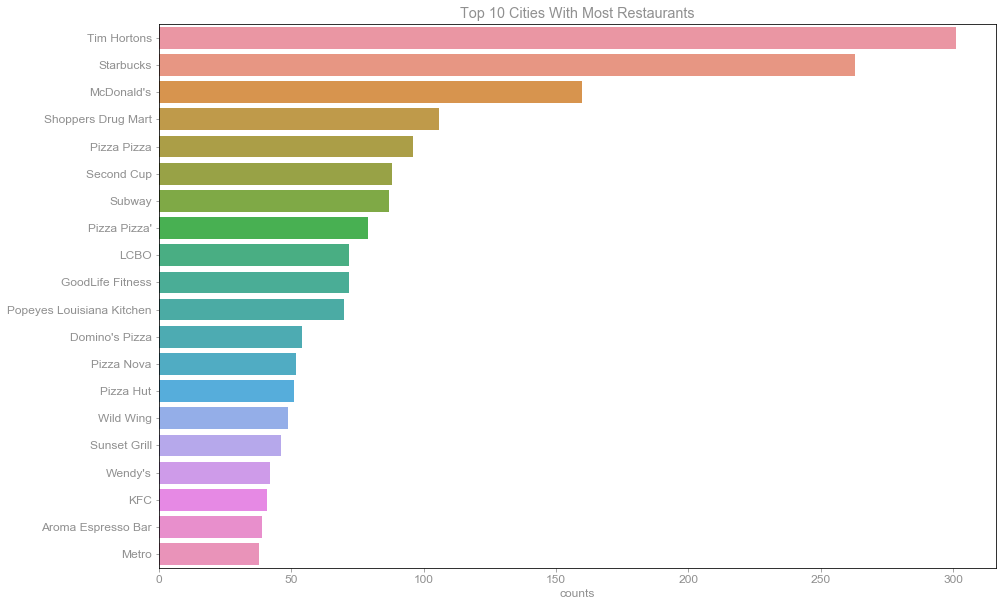

In [192]:
top_20_franchises.columns = ['counts']
plt.figure(figsize = (15, 10))
sns.barplot(y = top_20_franchises.index, x= top_20_franchises.counts, orient = 'h')
plt.title('Top 10 Cities With Most Restaurants')
plt.show()

In [193]:
grouped_GTA = GTA_business_df.groupby('modified_name').mean().sort_values(by = ['review_count'], ascending=False).reset_index().head(20)

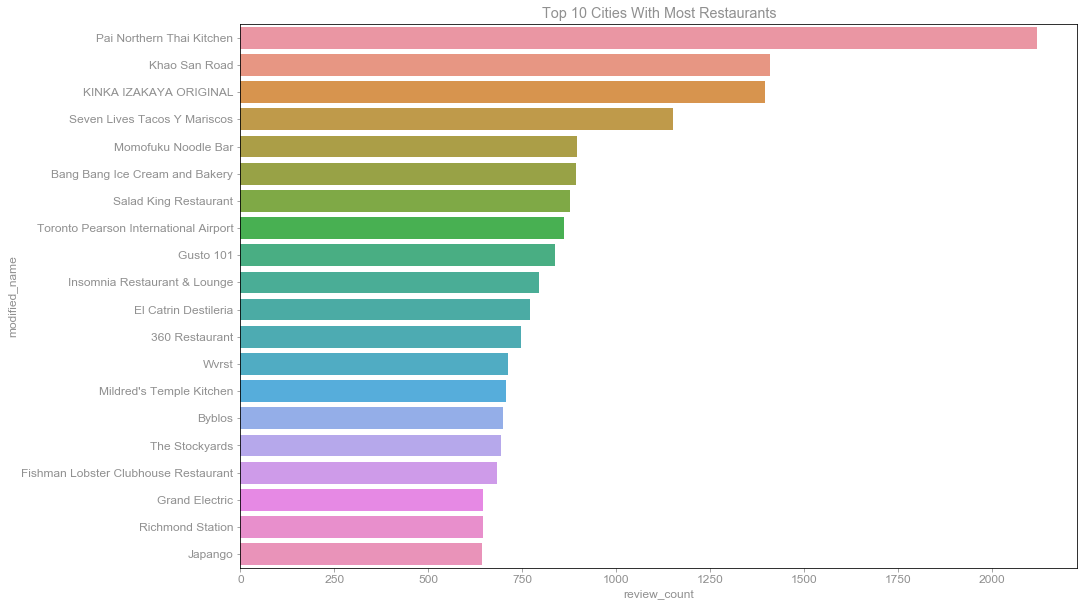

In [194]:
plt.figure(figsize = (15, 10))
sns.barplot(y = grouped_GTA.modified_name, x= grouped_GTA.review_count, orient = 'h')
plt.title('Top 10 Cities With Most Restaurants')
plt.show()

In [195]:
ontario_map = geopd.read_file("ontario_administrative/ontario_administrative.shp")

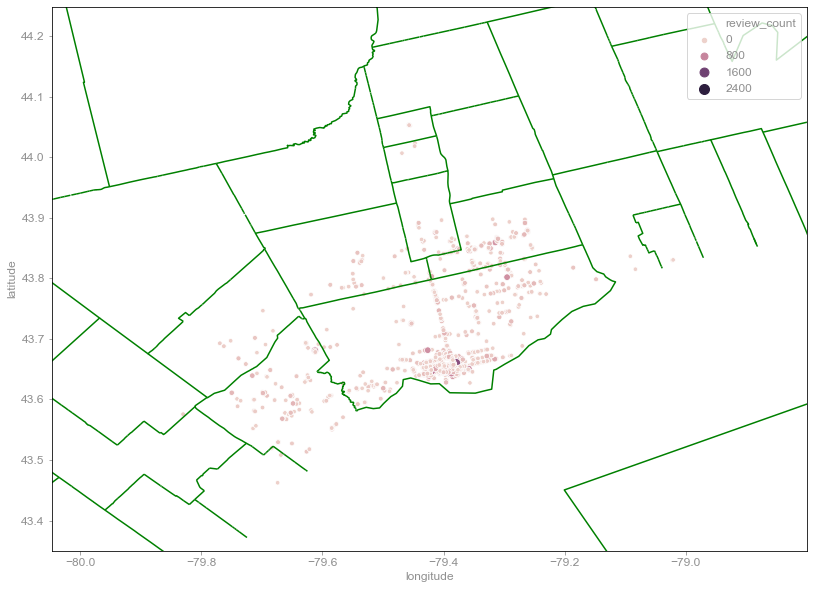

In [196]:
plt.figure(figsize=(15,10))
base = sns.scatterplot(x = "longitude", y = "latitude", size = "review_count", hue = "review_count", 
                       data = GTA_business_df[GTA_business_df['review_count'] > GTA_business_df['review_count'].quantile(0.95)], sizes = (20,100) )
ontario_map.plot(ax = base, edgecolor = 'green')
plt.xlim(GTA_business_df.longitude.min()-0.1, GTA_business_df.longitude.max()+0.1)
plt.ylim(GTA_business_df.latitude.min()-0.1, GTA_business_df.latitude.max()+0.1)
plt.show()

In [197]:
GTA_business_df['review_count'].quantile(0.95)

91.0

Then, we do it by city Toronto vs. Scarborough

In [223]:
Toronto_lis = []
for city in list(GTA_business_df['city'].unique()):
    if fuzz.partial_ratio(city, 'Toronto') > 80:
        Toronto_lis.append(city)

In [229]:
Toronto_lis.remove('Toronto Scarborough')
Toronto_lis.remove('Toronto-North York')

In [241]:
city_name_list = GTA_business_df['city']
city_name_list.replace(Toronto_lis, 'Toronto',  inplace = True)
GTA_business_df['modified_name'] = city_name_list
Toronto_business_df = GTA_business_df[GTA_business_df['modified_name'] == 'Toronto']
Other_business_df =  GTA_business_df[GTA_business_df['modified_name'] != 'Toronto']
GTA_business_df['city']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [245]:
Toronto_business_df.describe()

,latitude,longitude,stars,review_count,is_open
count,18917.000000,18917.000000,18917.000000,18917.000000,18917.000000
mean,43.678679,-79.395034,3.444309,27.019189,0.758154
std,0.043217,0.059830,0.934568,59.514319,0.428213
min,43.560365,-79.713930,1.000000,3.000000,0.000000
25%,43.650497,-79.418829,3.000000,4.000000,1.000000
50%,43.664215,-79.394156,3.500000,9.000000,1.000000
75%,43.688893,-79.375575,4.000000,24.000000,1.000000
max,43.881942,-79.019777,5.000000,2121.000000,1.000000


In [246]:
Other_business_df.describe()

,latitude,longitude,stars,review_count,is_open
count,14494.000000,14494.000000,14494.000000,14494.000000,14494.000000
mean,43.754779,-79.472357,3.241859,17.252311,0.840486
std,0.131590,0.194881,0.962590,32.993180,0.366168
min,43.450082,-79.947053,1.000000,3.000000,0.000000
25%,43.643640,-79.627240,2.500000,3.000000,1.000000
50%,43.774723,-79.473147,3.500000,6.000000,1.000000
75%,43.846546,-79.344323,4.000000,16.000000,1.000000
max,44.147909,-78.900077,5.000000,862.000000,1.000000


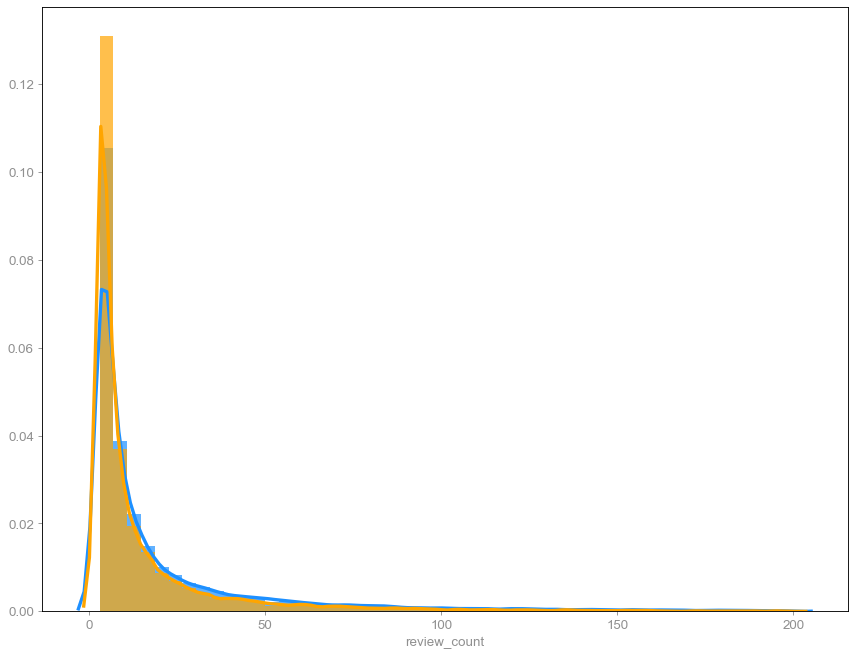

In [253]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(Toronto_business_df[Toronto_business_df.review_count.astype('int') < 200].review_count, color="dodgerblue", label="Compact", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(Other_business_df[Other_business_df.review_count.astype('int')  < 200].review_count, color="orange", label="SUV", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,country,restaurant,Bike Parking Availability,review_count_percentile,modified_name
19,zSpQmEBvRe3IhTUlMSA6HQ,Totum Life Science,"445 King Street W, Suite 101",Toronto,ON,M5V 1K4,43.645041,-79.395799,4.0,23,1,"{'AcceptsInsurance': 'True', 'ByAppointmentOnl...","Trainers, Health & Medical, Active Life, Physi...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",Canada,False,NaN,60_percentile,Toronto
26,C9oCPomVP0mtKa8z99E3gg,Bakery Gateau,"865 York Mills Road, Unit 1",Toronto,ON,M3B 1Y6,43.754093,-79.349548,4.5,8,1,"{'RestaurantsDelivery': 'False', 'RestaurantsP...","Bakeries, Food","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ...",Canada,False,True,40_percentile,Toronto
27,C9keC4mWuXdl2mYFHZXudQ,Uncle Otis Clothing,26 Bellair St,Toronto,ON,M5R 2C7,43.670744,-79.391385,5.0,12,1,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","Fashion, Sporting Goods, Men's Clothing, Shopp...","{'Monday': '11:30-19:0', 'Tuesday': '11:30-19:...",Canada,False,NaN,40_percentile,Toronto
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,1,"{'WiFi': 'u'no'', 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",Canada,True,True,80_percentile,Toronto
32,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve...","{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",Canada,True,True,60_percentile,Toronto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192554,5XwfpotCAvDzPyAulk_m5A,Starbucks,1 Adelaide St E,Toronto,ON,M5C 2V9,43.650161,-79.377797,3.5,6,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsPri...","Coffee & Tea, Food",None,Canada,False,True,20_percentile,Toronto
192568,_mo-QIcmJgUwcjeunAwtew,Espinosa Master Tailor,"221 Davenport Rd Toronto, ON M5R IJ3, Unit 9",Toronto,ON,M4W 1J5,43.674761,-79.395690,4.0,6,1,"{'RestaurantsPriceRange2': '3', 'WheelchairAcc...","Professional Services, Men's Clothing, Shoppin...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ...",Canada,False,NaN,20_percentile,Toronto
192583,lo8WwqKogC-kz4toRvkdUQ,KOKO! Share Bar,81 Yorkville Avenue,Toronto,ON,M5R 1C1,43.670948,-79.391502,3.5,47,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'f...","Korean, Japanese, Asian Fusion, Restaurants","{'Monday': '11:30-22:30', 'Tuesday': '11:30-22...",Canada,True,True,80_percentile,Toronto
192587,oS0CnUbyv0GUoD3L8_3UPQ,Thai Fantasy,578 Yonge Street,Toronto,ON,M4Y 1Z3,43.665120,-79.384809,4.0,113,1,"{'RestaurantsPriceRange2': '2', 'RestaurantsGo...","Restaurants, Thai","{'Monday': '0:0-0:0', 'Tuesday': '11:0-23:0', ...",Canada,True,True,80_percentile,Toronto


In [200]:
star_tim = GTA_business_df[(GTA_business_df['modified_name'] == 'Tim Hortons') | (GTA_business_df['modified_name'] == 'Starbucks')].reset_index(drop= True)

Then for every Tim Hortons, let's find a shortest starbucks nearby.

In [201]:
min_distance = []
for i in star_tim[star_tim['modified_name'] == 'Tim Hortons'].index:
    tim = GTA_business_df.iloc[i]
    temp = []
    for j in star_tim[star_tim['modified_name'] == 'Starbucks'].index:
            star = star_tim.iloc[j]
            dis = geopy.distance.distance((tim['latitude'], tim['longitude']), (star['latitude'], star['longitude'])).km
            temp.append(dis)
    m = min(temp)
    min_distance.append(m)

In [202]:
tim = star_tim[star_tim['modified_name'] == 'Tim Hortons']
tim['min_distance'] = min_distance

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


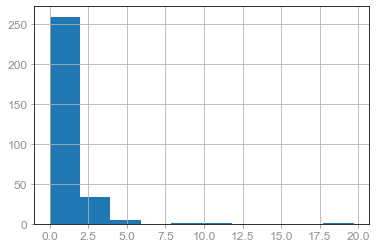

In [203]:
tim['min_distance'].astype(float).hist()

In [204]:
tim['min_distance'].astype(float).max()

19.712397088782897

In [205]:
tim['min_distance'].describe()

count    301.000000
mean       0.945922
std        1.594430
min        0.000000
25%        0.176248
50%        0.535468
75%        1.145576
max       19.712397
Name: min_distance, dtype: float64

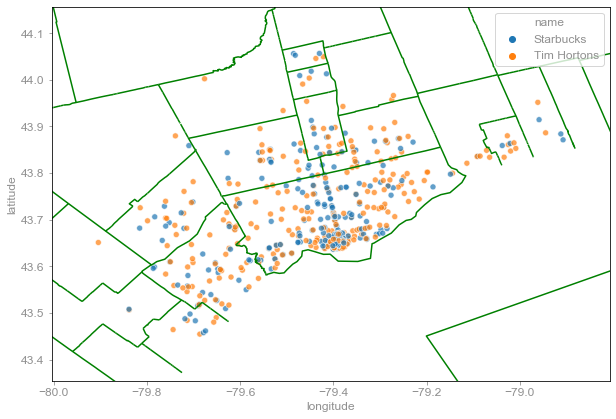

In [206]:
plt.figure(figsize=(10,15))
base = sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'name', data=star_tim, alpha=0.7)
ontario_map.plot(ax=base,edgecolor= 'green')
plt.xlim(star_tim.longitude.min()-0.1, star_tim.longitude.max()+0.1)
plt.ylim(star_tim.latitude.min()-0.1, star_tim.latitude.max()+0.1)
plt.show()

4

Since the file is too large to read, I will use 

In [254]:
review = pd.read_json("yelp_dataset/review.json", lines = True, chunksize = 500000)
review_subset = next(review)
while True: 
    try:
        review_subset = pd.concat([review_subset, next(review)])
    except StopIteration:
        print('Finish Loading')
        break
    except MemoryError:
        print('Memory Error')
        break

Finish Loading


In [255]:
user = pd.read_json("yelp_dataset/user.json", lines = True, chunksize = 500000)
user_subset = next(user)
while True: 
    try:
        user_subset = pd.concat([user_subset, next(user)])
    except StopIteration:
        print('Finish Loading')
        break
    except MemoryError:
        print('Memory Error')
        break

Finish Loading


1. Is there a small group of users responsible for most reviews?

In [259]:
review = review_subset

In [261]:
user = user_subset

In [262]:
user

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,...,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,...,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,14,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,...,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,...,1,0,0,1,16,57,80,80,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637133,oC4BjbB4I-wx5KBAO1k2Gg,Jiaxin,2,2016-02-24 19:28:47,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1637134,LKd_-BT2GMWp8_1ho18kOg,Wes,8,2017-02-25 23:34:05,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1637135,ib_elCBhGOamS0AALkh4Og,Lee,4,2009-08-19 22:08:16,8,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1637136,WV27LoSFDG_YmiDKTLKKLA,Melissa,1,2018-10-15 17:07:43,1,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [263]:
review.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36


In [264]:
user.head(1)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,...,0,0,0,0,1,1,1,1,2,0


In [266]:
len(review)

6685900

In [267]:
len(user)

1637138

4.1  Is there a small group of users responsible for most reviews?
The procedure I will use for this question is to find attributes that are meaningful to form a group.

In [269]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

Among all attributes, **elite**, **fans**, **compliment_total** may relates to the review counts. Therefore, I will plot the distribution for them

What makes a great Yelp Elite Squad member?
Thoughtful reviews
Awesome photos
Sending compliments
Up-voting reviews

In [272]:
user['review_count'].describe()

count    1.637138e+06
mean     2.228770e+01
std      7.692236e+01
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.500000e+01
max      1.327800e+04
Name: review_count, dtype: float64

In [277]:
elite_user = user[user['elite'] != ''] 

In [284]:
total_review_elite_ratio = sum(elite_user.review_count) / sum(user.review_count)

In [287]:
total_elite_ratio = elite_user.shape[0]/user.shape[0]

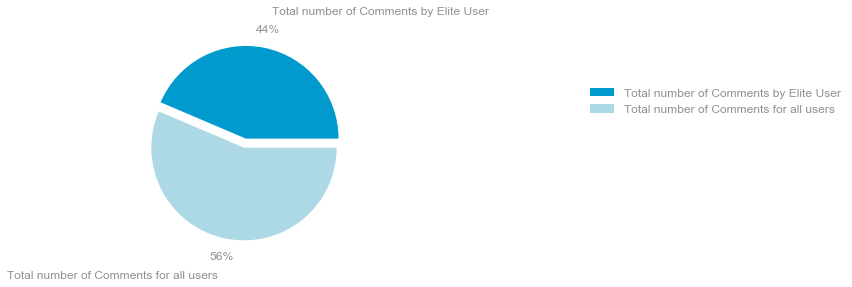

In [286]:
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Total number of Comments by Elite User', 
         'Total number of Comments for all users']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
percentages = [total_review_elite_ratio, 1 -total_review_elite_ratio]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

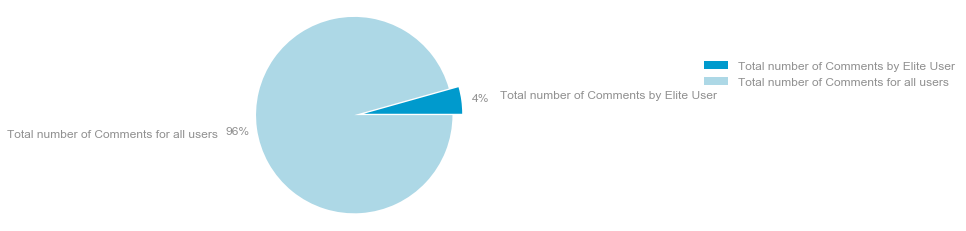

In [288]:
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Total number of Comments by Elite User', 
         'Total number of Comments for all users']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
percentages = [total_elite_ratio, 1 -total_elite_ratio]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

From the pie chart, we see that only 4 percent of users are elite. They contribute more than 40% of comments. Therefore, elite group is a small group that contributes to most reviews.

In [289]:
user['fans'].describe()

count    1.637138e+06
mean     1.465646e+00
std      1.568317e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.538000e+03
Name: fans, dtype: float64

In [291]:
user['fans'].quantile(0.95)

4.0

In [297]:
have_fans = user[user['fans'] > 3]

In [298]:
total_review_have_fans_ratio = sum(have_fans.review_count) / sum(user.review_count)
total_have_fans_ratio = have_fans.shape[0]/user.shape[0]

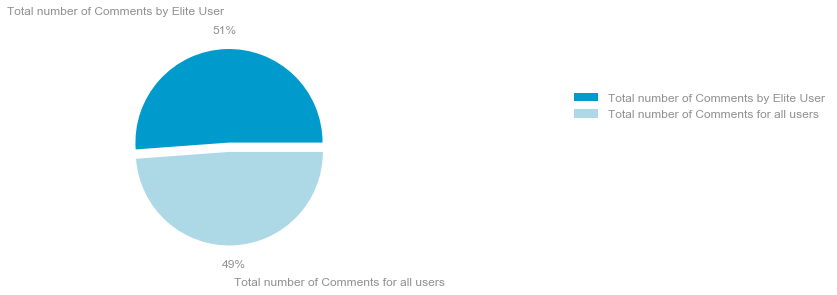

In [299]:
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Total number of Comments by Elite User', 
         'Total number of Comments for all users']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
percentages = [total_review_have_fans_ratio, 1 -total_review_have_fans_ratio]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

In [ ]:
total_review_have_fans_ratio = sum(have_fans.review_count) / sum(user.review_count)
total_have_fans_ratio = have_fans.shape[0]/user.shape[0]

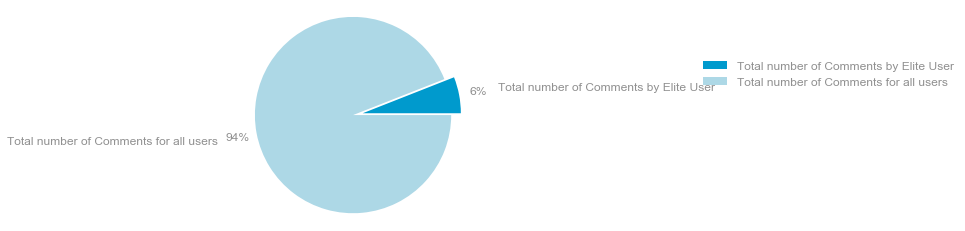

In [300]:
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Total number of Comments by Elite User', 
         'Total number of Comments for all users']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
percentages = [total_have_fans_ratio, 1 -total_have_fans_ratio]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

Using the same procedure, we see there are only 6% of users have at least 4 fans, but they contribute to more than 50 percent of the comments. And in fact, we can see most elite users have more than 3 fans.

In [302]:
elite_have_fans_ratio = elite_user[elite_user['fans']>3].shape[0]/elite_user.shape[0]

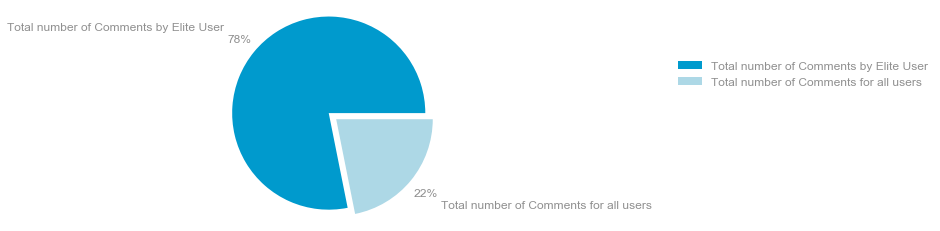

In [303]:
fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Total number of Comments by Elite User', 
         'Total number of Comments for all users']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
percentages = [elite_have_fans_ratio, 1 -elite_have_fans_ratio]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

2. Do Yelp reviewers use similar language in their reviews of GTA's Tim Horton's and Starbucks? What about for the subset of users who reviewed both establishments?

By previous part, we know Tim Horton's and Starbucks are two most common franchises in GTA. Which one is better in Toronto citiezen's view? for How do people actually think of them? These are controversial questions, but this dataset may give us an answer to this question. 
The procedure I use to answer this question is 

1. Select the dataframe of reviews about GTA's Tim Horton's and Starbucks.
2. Extract the keyword in the reviews, compare and contrast them.
3. Find characteristcs of reviews written by users who reviewed both establishments.

In [ ]:
merged_timstar_review = pd.merge(star_tim, review, on='business_id')

In [320]:
tim_review = merged_timstar_review[merged_timstar_review['name'] == 'Tim Hortons']
star_review = merged_timstar_review[merged_timstar_review['name'] == 'Starbucks']

In [318]:
merged_timstar_review.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,review_count_percentile,modified_name,review_id,user_id,stars_y,useful,funny,cool,text,date
0,Mq6qiz-Bxgd8VE6tBwCuUg,Starbucks,190 Queen Street E,Brampton,ON,L6W 2B3,43.693769,-79.752138,4.5,5,...,20_percentile,Starbucks,38xv91m75rxoeIBNa53Ipg,e0AUdCu-jeOkLImiEzlTDg,4,1,0,3,"Okay, it's Starbucks - what do you need to kno...",2016-11-30 01:34:59
1,Mq6qiz-Bxgd8VE6tBwCuUg,Starbucks,190 Queen Street E,Brampton,ON,L6W 2B3,43.693769,-79.752138,4.5,5,...,20_percentile,Starbucks,2BQ2S1pDj_V4AW9Ugjr-nA,gUHGfOpInuzNVvoH6w0K9g,4,1,0,1,I was never huge on Starbucks but this locatio...,2017-05-10 05:00:45
2,Mq6qiz-Bxgd8VE6tBwCuUg,Starbucks,190 Queen Street E,Brampton,ON,L6W 2B3,43.693769,-79.752138,4.5,5,...,20_percentile,Starbucks,QdmtH3ARY-jCqwIJmq4Iqg,Ko4y7jIissMR8ZGQlMdpaA,4,0,0,0,Pros\n\n- Drive Through \n- Great staff \n- Qu...,2017-02-04 16:41:31
3,Mq6qiz-Bxgd8VE6tBwCuUg,Starbucks,190 Queen Street E,Brampton,ON,L6W 2B3,43.693769,-79.752138,4.5,5,...,20_percentile,Starbucks,76RVmT4fRhj95YKv8z33pQ,2eFPk8sQz6xy8i2cdCrQfg,5,0,0,0,Brand spanking new Starbucks with a drive thro...,2018-04-11 16:02:26
4,Mq6qiz-Bxgd8VE6tBwCuUg,Starbucks,190 Queen Street E,Brampton,ON,L6W 2B3,43.693769,-79.752138,4.5,5,...,20_percentile,Starbucks,PHDnl67qQpQCVAwlm8f97w,Zof5LevynuBuY00HNbbhlA,5,1,0,1,You can't miss this location driving by it on ...,2016-12-17 12:28:59
5,jdgkNUgWTZ4_vqVHHqFk6g,Tim Hortons,1750 Bayly Street,Pickering,ON,L1W 3N3,43.833891,-79.064991,1.5,3,...,0_percentile,Tim Hortons,hZcSvvf7QxbxSkEL9pClQA,UhlXS6NdA5k4SRunpcKHJw,2,1,0,1,I ordered their special for two sandwiches for...,2018-03-09 13:09:18
6,jdgkNUgWTZ4_vqVHHqFk6g,Tim Hortons,1750 Bayly Street,Pickering,ON,L1W 3N3,43.833891,-79.064991,1.5,3,...,0_percentile,Tim Hortons,l_8WEmH7g78o8ExKZTkL5g,UhlXS6NdA5k4SRunpcKHJw,4,1,0,1,"compared to the last Tim Hortons i visited, th...",2015-02-27 12:35:12
7,jdgkNUgWTZ4_vqVHHqFk6g,Tim Hortons,1750 Bayly Street,Pickering,ON,L1W 3N3,43.833891,-79.064991,1.5,3,...,0_percentile,Tim Hortons,nx9TBlu-LZHlHbWUv7PLQA,UhlXS6NdA5k4SRunpcKHJw,1,0,0,0,you screwed up my order again. I'm sick of pa...,2017-12-12 13:37:33
8,jdgkNUgWTZ4_vqVHHqFk6g,Tim Hortons,1750 Bayly Street,Pickering,ON,L1W 3N3,43.833891,-79.064991,1.5,3,...,0_percentile,Tim Hortons,U1udOZmz-AEDYa-vK0abPA,laD4LK2UJLrwsvNDIUqLNw,1,1,0,0,This place was horrible! Dark roast was like ...,2016-05-02 12:16:29
9,jdgkNUgWTZ4_vqVHHqFk6g,Tim Hortons,1750 Bayly Street,Pickering,ON,L1W 3N3,43.833891,-79.064991,1.5,3,...,0_percentile,Tim Hortons,3q2SEF6zlUSdKlxOipg9Uw,93k9F27TQnFqiIw8YYxNuA,2,1,0,0,I've only been here during the day: it always ...,2013-06-20 16:09:01


From previous research, we see review in Yelp is a very powerful tool to determine. However, its limitation is also obvious, accoring to  

In [342]:
temp = tim_review.at[5,'text']

In [358]:
temp = re.sub(r'[^\w\s]','',temp)

In [359]:
temp.lower().split()

['i',
 'ordered',
 'their',
 'special',
 'for',
 'two',
 'sandwiches',
 'for',
 '5',
 'so',
 'i',
 'should',
 'have',
 'got',
 'a',
 'receipt',
 'they',
 'charged',
 'me',
 'full',
 'price',
 'not',
 'the',
 'advertised',
 'price',
 'not',
 'impressed',
 'and',
 'the',
 'worst',
 'part',
 'is',
 'the',
 'sandwiches',
 'were',
 'cold',
 'i',
 'think',
 'i',
 'need',
 'to',
 'break',
 'the',
 'hortons',
 'habit',
 'once',
 'and',
 'for',
 'all']

In [355]:
s = "string. With. Punctuation?"
s = re.sub(r'[^\w\s]','',s)

In [365]:
def get_key_word_dict(df):
    dic = {}
    for s in df.text:
        s = re.sub(r'[^\w\s]','',s)
        s = s.lower().split()
        for w in s:
            if w not in dic:
                dic[w] = 1
            else:
                dic[w] = dic[w] + 1
    return dic

In [397]:
def add_word_type(df):
    lis = []
    for w in df.word:
        if len(wn.synsets(w)) == 0:
            lis.append(np.nan)
        else:
            lis.append(wn.synsets(w)[0].pos())
    df['type'] = lis   

In [398]:
tim_word_count = pd.DataFrame.from_dict(get_key_word_dict(tim_review), orient='index')
tim_word_count.columns = ['count']
tim_word_count.reset_index(inplace = True) 
tim_word_count.columns = ['word','count']

In [399]:
add_word_type(tim_word_count)

In [403]:
grouped_tim_word_count = tim_word_count.groupby('type')

In [410]:
grouped_tim_word_count.get_group('n').sort_values(by='count', ascending=False).head(20)

,word,count,type
12,a,4157,n
0,i,4116,n
94,in,1959,n
82,it,1940,n
43,was,1634,n
88,coffee,1114,n
10,have,1067,n
49,at,1052,n
144,are,996,n
307,location,914,n


Now, both of them

In [411]:
merged_timstar_review.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'country', 'restaurant',
       'Bike Parking Availability', 'review_count_percentile', 'modified_name',
       'review_id', 'user_id', 'stars_y', 'useful', 'funny', 'cool', 'text',
       'date'],
      dtype='object')

In [413]:
tim_star_intersection = pd.concat([tim_review,star_review])
tim_star_intersection = tim_star_intersection[tim_star_intersection.duplicated('user_id', keep=False)]

### paid reviewers
My procedure: 
1. select review > 10 and star == 5
2. select review and use word detection

In [415]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [416]:
suspects = user[(user['review_count'] > 9) & (user['average_stars'] ==  5)]

In [417]:
suspects

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
54,Kgv4_8tmBIeZmVYu3rUhVg,Bryan,14,2015-03-24 17:57:28,0,0,0,,"9kzI7g3guA2g76azFiVRKg, 2Yvam0hTZte4nqjsqyYNqQ...",0,...,0,0,0,0,0,0,0,0,0,0
560,Aqz1DKxUb7vI3d6C3eDejw,Matt,18,2012-12-03 00:55:11,17,3,7,,"RykbuCq1zI1coQmkg_AqYg, S1QO0UhUGQpBy4uZ4gZtqA...",0,...,0,0,0,0,1,0,0,0,0,0
638,FCZL3pgFmZ59aE1q2yv20g,Niki,18,2014-06-29 20:24:54,34,10,28,,"gk9a6St20vQ87MRBFhuggg, s0DX_KzUAbZAbRIcRudDNg...",2,...,0,0,0,0,0,0,0,0,0,0
815,_FccFskO8grJYC9GgaVJhQ,Michael,12,2015-06-25 01:38:38,2,1,1,,"TobOg8U3b-lwI2dXXIVnrQ, L4ymUs6vqt3yL1ifjQeO1A...",0,...,0,0,0,0,0,0,0,0,0,0
994,7kmPZogSiXwCXo8Z7NMGlA,Michael,11,2015-08-15 16:48:27,12,2,3,,"GxEz5SJ_Mzc7ifliGOD-DA, 2gOTPmE2Yrq3S7DtyCwD5g...",1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633415,bIigRUXeTesFA6woY14-kw,Valerie,10,2016-07-22 01:57:29,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1635046,2bt7O37OHxgFwgas6S7Naw,Lacey,12,2017-08-15 00:55:18,19,1,2,,None,1,...,0,0,0,0,0,0,0,0,0,0
1635438,RXPwX4eQKIPWsPpsCb3RQw,Allen,10,2011-09-30 00:24:46,3,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1635672,tG8KnwT-NAqDka7fB0RU5A,Scott,13,2015-04-04 00:50:30,2,0,1,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [424]:
review[review['user_id'] == 'bIigRUXeTesFA6woY14-kw']

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
6010713,zzmmxsCQuBYV3RdXLOUGig,bIigRUXeTesFA6woY14-kw,wctvZYbHAo8jufqAFQ457g,5,0,0,0,We've been here a few times and its always bee...,2018-10-15 01:21:15


In [423]:
bussiness_df[bussiness_df['business_id'] == 'FmBHDfb-ZKzLDxQBQXGMfw']

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,country,restaurant,Bike Parking Availability,review_count_percentile
183968,FmBHDfb-ZKzLDxQBQXGMfw,Anchor Chiropractic,"5135 S Fort Apache Rd, Ste 140",Las Vegas,NV,89148,36.095005,-115.298158,4.0,21,1,"{'AcceptsInsurance': 'True', 'ByAppointmentOnl...","Health & Medical, Chiropractors","{'Monday': '15:0-19:0', 'Tuesday': '15:0-18:0'...",United States,False,NaN,60_percentile
